In [21]:
import os
import torch
import pandas as pd
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.optim import lr_scheduler
from sklearn import model_selection
from sklearn import metrics
import transformers
import tokenizers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm.autonotebook import tqdm
from tokenizers import BertWordPieceTokenizer
import matplotlib.pyplot as plt
import torch.nn as nn
import seaborn as sns
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
print(torch.cuda.is_available())

torch.cuda.empty_cache()
import warnings
warnings.filterwarnings('ignore')

True


pip install torch pandas scikit-learn transformers tokenizers tqdm matplotlib seaborn
Run this in the terminal first


In [22]:
df_train = pd.read_json('../../Datasets/embold_train.json')
df_extended = pd.read_json('../../Datasets/embold_train_extra.json')
df_test = pd.read_json('../../Datasets/embold_test.json')

KeyboardInterrupt: 

In [ ]:
df_train = pd.concat([df_train, df_extended], axis=0).reset_index(drop=True)
df_train.head()
df_train.shape

(450000, 3)

Total Counts of label column: 
 label
1    207318
0    200481
2     42201
Name: count, dtype: int64


<Axes: xlabel='label', ylabel='count'>

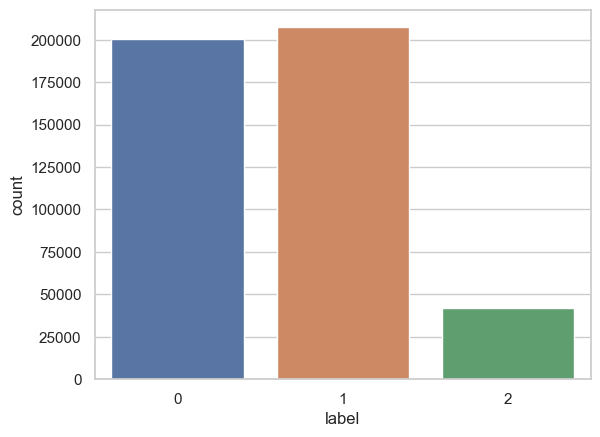

In [ ]:
print('Total Counts of label column: \n'.format(),df_train['label'].value_counts())
sns.set(style="whitegrid", color_codes=True)
sns.countplot(x='label', data=df_train)

Now we need to downsample this data to balance it


Total Counts of label column: 
 label
0    42201
1    42201
2    42201
Name: count, dtype: int64


<Axes: xlabel='label', ylabel='count'>

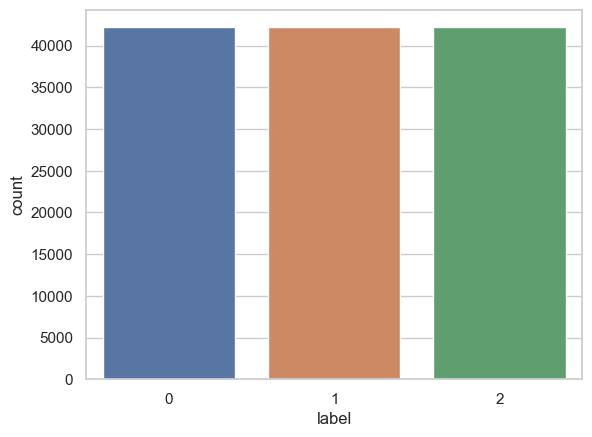

In [ ]:
df_train_0 = df_train[df_train['label']==0]
df_train_1 = df_train[df_train['label']==1]
df_train_2 = df_train[df_train['label']==2]
df_train_0 = df_train_0.sample(n=df_train_2.shape[0], random_state=42)
df_train_1 = df_train_1.sample(n=df_train_2.shape[0], random_state=42)
df_train = pd.concat([df_train_0, df_train_1, df_train_2], axis=0).reset_index(drop=True)
df_train.head()
print('Total Counts of label column: \n'.format(),df_train['label'].value_counts())
sns.set(style="whitegrid", color_codes=True)
sns.countplot(x='label', data=df_train)

In [ ]:
df_train['text'] = df_train.apply(lambda x: x['title'] + ' ' + x['body'],axis=1)
df_train.head()

,title,body,label,text
0,offset div can not click in safari,when the div which will hold gio globe have of...,0,offset div can not click in safari when the di...
1,textfield should manage the enabled state,the text field component exposes its wrapped t...,0,textfield should manage the enabled state the ...
2,message sanitation for ipaddresses does not ca...,for example:\r \r >>> ip = ' 2a03:f80:ed15:...,0,message sanitation for ipaddresses does not ca...
3,failed after uploading x volume s . error mess...,_from soski...@gmail.com https://code.google...,0,failed after uploading x volume s . error mess...
4,parsing error \ log_file_id\ key in resource/...,change \ \ log_daemon_id\ to \ log_file_id\ ...,0,parsing error \ log_file_id\ key in resource/...


In [ ]:
import nltk
import re
import string
from string import punctuation
from nltk.corpus import stopwords

def clean_text(text):
    text = text.replace("\\r", "")
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


def remove_stopwords(git_text):
    remove_punctuation = [ch for ch in git_text if ch not in punctuation]
    remove_punctuation = "".join(remove_punctuation).split()
    filtered_git_text = [word.lower() for word in remove_punctuation if word.lower() not in stopwords.words('english')]
    filtered_git_text = " ".join(filtered_git_text)
    return filtered_git_text


In [ ]:
# df_train['text'] = df_train['text'].apply(lambda x: clean_text(x))
# df_train["text"] = df_train["text"].apply(remove_stopwords)
df_train = pd.read_json('../../Datasets/embold_train_cleaned.json', lines=True)
df_train.head()
# df_train.to_json('../../Datasets/embold_train_cleaned.json', orient='records', lines=True)

,title,body,label,text
0,offset div can not click in safari,when the div which will hold gio globe have of...,0,offset div click safari div hold gio globe off...
1,textfield should manage the enabled state,the text field component exposes its wrapped t...,0,textfield manage enabled state text field comp...
2,message sanitation for ipaddresses does not ca...,for example:\r \r >>> ip = ' 2a03:f80:ed15:...,0,message sanitation ipaddresses call generic sa...
3,failed after uploading x volume s . error mess...,_from soski...@gmail.com https://code.google...,0,failed uploading x volume error message except...
4,parsing error \ log_file_id\ key in resource/...,change \ \ log_daemon_id\ to \ log_file_id\ ...,0,parsing error logfileid key resourcedefaultcon...


In [ ]:
class config:
    MAX_LEN = 128
    TRAIN_BATCH_SIZE = 8
    VALID_BATCH_SIZE = 8
    EPOCHS = 10
    BERT_PATH = "bert-base-uncased"
    MODEL_PATH = "bert-base-uncased/pytorch_model.bin"
    TRAINING_FILE = "../../Datasets/embold_train_cleaned.json"
    TOKENIZER = BertTokenizer.from_pretrained(BERT_PATH, do_lower_case=True)
    truncation = True

In [ ]:
device = "cpu"
if(torch.cuda.is_available()):
    device = "cuda"
model = BertModel.from_pretrained(config.BERT_PATH)
tokenizer = config.TOKENIZER
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
class Git_Message(Dataset):
    def __init__(self, git_messages, label, tokenizer, max_len):
        self.git_messages = git_messages
        self.label = label
        self.tokenizer = tokenizer
        self.max_len = config.MAX_LEN
    
    def __len__(self):
        return len(self.git_messages)

    def __getitem__(self, item):
        git_messages = str(self.git_messages[item])
        label = self.label[item]
        
        encoding = self.tokenizer.encode_plus(
        git_messages,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
        truncation=config.truncation,
        )
        return {
         'input_ids': encoding['input_ids'].squeeze(),
         'attention_mask': encoding['attention_mask'].squeeze(),
         'label': torch.tensor(label, dtype=torch.long)
          }

Total Counts of label column: 
 label
2    5000
1    5000
0    5000
Name: count, dtype: int64


((12000, 4), (1500, 4), (1500, 4))

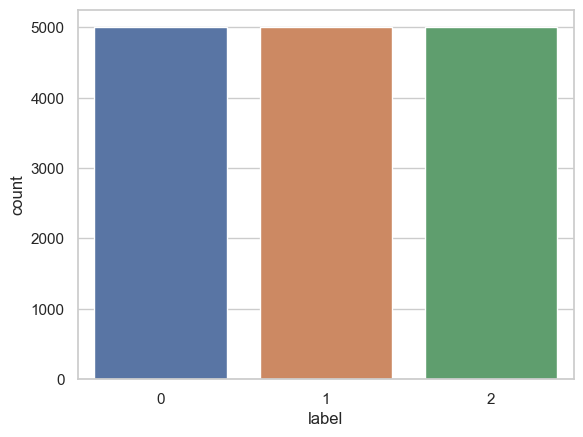

In [ ]:
df_class_0 = df_train[df_train['label'] == 0].sample(5000, replace=True)
df_class_1 = df_train[df_train['label'] == 1].sample(5000, replace=True)
df_class_2 = df_train[df_train['label'] == 2].sample(5000, replace=True)

df_train = pd.concat([df_class_0, df_class_1, df_class_2], axis=0).reset_index(drop=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

print('Total Counts of label column: \n'.format(),df_train['label'].value_counts())
sns.set(style="whitegrid", color_codes=True)
sns.countplot(x='label', data=df_train)
training_data , testing_data = model_selection.train_test_split(df_train, test_size=0.2, random_state=42)
testing_data, validation_data = model_selection.train_test_split(testing_data, test_size=0.5, random_state=42)
training_data.shape, testing_data.shape, validation_data.shape

In [ ]:
def create_data_loader(data, tokenizer, max_len, batch_size):
    
    ds = Git_Message(git_messages=data.text.to_numpy(),
    label=data.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len)
    
    return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=0)


train_data_loader = create_data_loader(training_data, config.TOKENIZER, config.MAX_LEN, config.TRAIN_BATCH_SIZE)
testing_data_loader = create_data_loader(testing_data, config.TOKENIZER, config.MAX_LEN, config.VALID_BATCH_SIZE)
val_data_loader = create_data_loader(validation_data, config.TOKENIZER, config.MAX_LEN, config.VALID_BATCH_SIZE)


In [ ]:
class BugPredictor(nn.Module):
    
    def __init__(self, n_classes):
        super(BugPredictor, self).__init__()
        self.bert_model = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(p=0.0)
        self.out = nn.Linear(self.bert_model.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert_model(
        input_ids=input_ids,
        attention_mask = attention_mask
        )
        output = self.dropout(outputs[1])
        return self.out(output)

In [ ]:
class_names = [0, 1, 2]
bug_predictor_model = BugPredictor(len(class_names)).to(device)


In [ ]:
EPOCHS = 10

optimizer = AdamW(bug_predictor_model.parameters(), lr=1e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    
    losses = []
    correct_predictions = 0
    total_len = len(data_loader)
    i=1
    for d in data_loader:
        print("Training Batch: {}/{}".format(i, total_len))
        i+=1
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['label'].to(device)
        outputs = model(input_ids = input_ids, attention_mask = attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        
        correct_predictions += torch.sum(preds==targets)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double()/n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    total_len = len(data_loader)
    i=1
    
    with torch.no_grad():
        for d in data_loader:
            print("Validation Batch: {}/{}".format(i, total_len))
            i+=1
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['label'].to(device)

            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds==targets)
            losses.append(loss.item())
    
    return correct_predictions.double()/n_examples, np.mean(losses)

In [ ]:
%%time
from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print('EPOCH {}/{}'.format(epoch+1,EPOCHS))
    print('-' * 10)
  
    train_acc, train_loss = train_model(bug_predictor_model, train_data_loader, loss_fn, optimizer, device, scheduler, len(training_data))

    print('Train loss : {} accuracy : {}'.format(train_loss, train_acc))
    
    val_acc, val_loss = eval_model(bug_predictor_model, val_data_loader, loss_fn, device, len(validation_data))
    
    print('Validation loss : {} accuracy : {}'.format(val_loss, val_acc))
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        print('Saving the best model ...')
        torch.save(bug_predictor_model.state_dict(), 'best_model.bin')
        best_accuracy = val_acc

EPOCH 1/10
----------
Training Batch: 1/1500
Training Batch: 2/1500
Training Batch: 3/1500
Training Batch: 4/1500
Training Batch: 5/1500
Training Batch: 6/1500
Training Batch: 7/1500
Training Batch: 8/1500
Training Batch: 9/1500
Training Batch: 10/1500
Training Batch: 11/1500
Training Batch: 12/1500
Training Batch: 13/1500
Training Batch: 14/1500
Training Batch: 15/1500
Training Batch: 16/1500
Training Batch: 17/1500
Training Batch: 18/1500
Training Batch: 19/1500
Training Batch: 20/1500
Training Batch: 21/1500
Training Batch: 22/1500
Training Batch: 23/1500
Training Batch: 24/1500
Training Batch: 25/1500
Training Batch: 26/1500
Training Batch: 27/1500
Training Batch: 28/1500
Training Batch: 29/1500
Training Batch: 30/1500
Training Batch: 31/1500
Training Batch: 32/1500
Training Batch: 33/1500
Training Batch: 34/1500
Training Batch: 35/1500
Training Batch: 36/1500
Training Batch: 37/1500
Training Batch: 38/1500
Training Batch: 39/1500
Training Batch: 40/1500
Training Batch: 41/1500
Tra

NameError: name 'time' is not defined

In [ ]:
bug_predictor_model.load_state_dict(torch.load('best_model.bin'))
test_acc, _ = eval_model(bug_predictor_model, testing_data_loader, loss_fn, device, len(testing_data))
print('Test Accuracy : {}%'.format(test_acc.item()*100))


Validation Batch: 1/125
Validation Batch: 2/125
Validation Batch: 3/125
Validation Batch: 4/125
Validation Batch: 5/125
Validation Batch: 6/125
Validation Batch: 7/125
Validation Batch: 8/125
Validation Batch: 9/125
Validation Batch: 10/125
Validation Batch: 11/125
Validation Batch: 12/125
Validation Batch: 13/125
Validation Batch: 14/125
Validation Batch: 15/125
Validation Batch: 16/125
Validation Batch: 17/125
Validation Batch: 18/125
Validation Batch: 19/125
Validation Batch: 20/125
Validation Batch: 21/125
Validation Batch: 22/125
Validation Batch: 23/125
Validation Batch: 24/125
Validation Batch: 25/125
Validation Batch: 26/125
Validation Batch: 27/125
Validation Batch: 28/125
Validation Batch: 29/125
Validation Batch: 30/125
Validation Batch: 31/125
Validation Batch: 32/125
Validation Batch: 33/125
Validation Batch: 34/125
Validation Batch: 35/125
Validation Batch: 36/125
Validation Batch: 37/125
Validation Batch: 38/125
Validation Batch: 39/125
Validation Batch: 40/125
Validatio

In [ ]:
def predict_git_category(sample_message, model):
    sample_message = remove_stopwords(clean_text(sample_message))
    encoded_message = tokenizer.encode_plus(sample_message, max_length=config.MAX_LEN,truncation=True, add_special_tokens=True, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True, return_tensors='pt')
    input_ids = encoded_message['input_ids'].to(device)
    attention_mask = encoded_message['attention_mask'].to(device)
    
    output = model(input_ids=input_ids, attention_mask=attention_mask)
    _, prediction_idx = torch.max(output, dim=1)
    class_names = ['bug', 'feature', 'question']
      
    return class_names[prediction_idx]

In [ ]:
sample_bug_message = "my appointment functionality is not working"
bug_predictor_model.load_state_dict(torch.load('best_model.bin'))

print('Sample bug message : ', sample_bug_message)
print('Predicted GitHub Category : ', predict_git_category(sample_bug_message, bug_predictor_model))

Sample bug message :  my appointment functionality is not working
Predicted GitHub Category :  bug


Total Counts of label column: 
 label
0    3333
2    3333
1    3333
Name: count, dtype: int64


<Axes: xlabel='label', ylabel='count'>

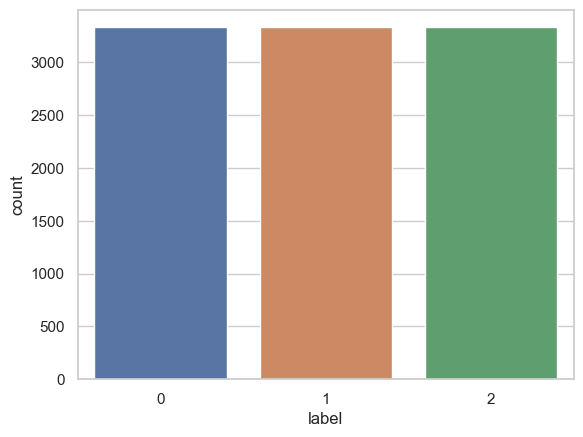

In [ ]:
print('Total Counts of label column: \n'.format(),df_train['label'].value_counts())
sns.set(style="whitegrid", color_codes=True)
sns.countplot(x='label', data=df_train)